# Portfolio Assignment: Text Classification 2

Linus Fackler

Here, we will compare different architectures like RNN, CNN, etc.
Our dataset is from Kaggle and can be found under: https://www.kaggle.com/datasets/kritanjalijain/amazon-reviews
It is a collection of Amazon reviews that are either positive or negative.

### Imports

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sb
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from wordcloud import WordCloud, STOPWORDS
import tensorflow as tf
import tensorflow_hub as hub

## Preprocessing the data

### Read Data

The original dataset contains over 34 million rows, and loading this data always takes an unnecessary amount of time. So instead of loading it and then cutting it down in the notebook, I decided to just edit the CSV files to 100k rows to save time.

It also didn't contain any headers, so I added "is_positive", "title", and "description".

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP Text Classification/amazon_reviews.csv')
print("Train:", df.shape)
print("\nTrain types:\n", df.dtypes, sep='')
print()
df[:10]

Train: (100000, 3)

Train types:
is_positive     int64
title          object
review         object
dtype: object



,is_positive,title,review
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,2,Amazing!,This soundtrack is my favorite music of all ti...
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."
5,2,an absolute masterpiece,I am quite sure any of you actually taking the...
6,1,Buyer beware,"This is a self-published book, and if you want..."
7,2,Glorious story,I loved Whisper of the wicked saints. The stor...
8,2,A FIVE STAR BOOK,I just finished reading Whisper of the Wicked ...
9,2,Whispers of the Wicked Saints,This was a easy to read book that made me want...


Just to make it less confusing, I will change 2 to 1 and 1 to 0.
Here, 1 is positive and 0 is negative.

In [5]:
# negative -> 0
df.loc[df['is_positive'] == 1, 'is_positive'] = 0

# positive -> 1
df.loc[df['is_positive'] == 2, 'is_positive'] = 1

In [6]:
df[:10]

,is_positive,title,review
0,1,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,1,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,1,Amazing!,This soundtrack is my favorite music of all ti...
3,1,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,1,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."
5,1,an absolute masterpiece,I am quite sure any of you actually taking the...
6,0,Buyer beware,"This is a self-published book, and if you want..."
7,1,Glorious story,I loved Whisper of the wicked saints. The stor...
8,1,A FIVE STAR BOOK,I just finished reading Whisper of the Wicked ...
9,1,Whispers of the Wicked Saints,This was a easy to read book that made me want...


### Distribution of Target Classes

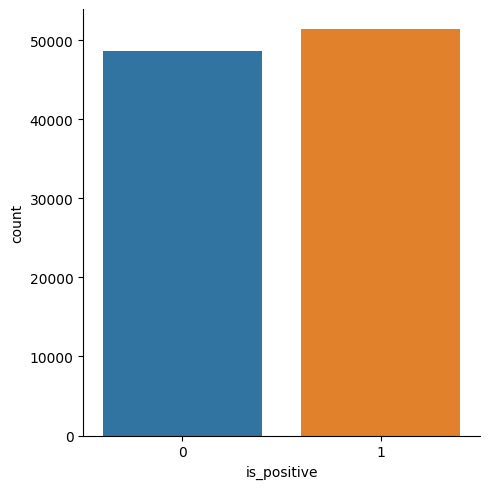

In [7]:
sb.catplot(x='is_positive', kind='count', data=df)

### Visualize most important words

These are the most important words in the reviews of the data set for each positive and negative reviews.

#### Review - positive

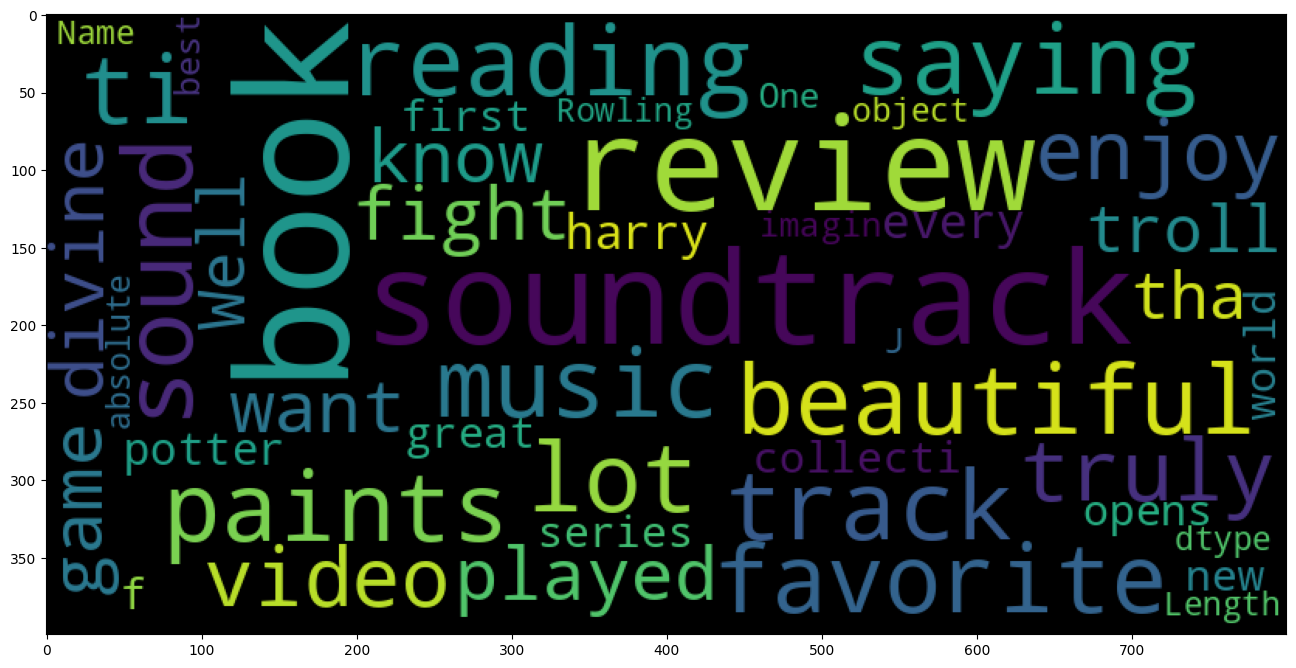

In [8]:
wordcloud = WordCloud(background_color = 'black', stopwords = STOPWORDS, max_words = 100, max_font_size = 100, random_state = 15, width = 800, height = 400)

plt.figure(figsize = (16, 12))
wordcloud.generate(str(df.loc[df['is_positive'] == 1, 'review']))
plt.imshow(wordcloud)

#### Review - negative

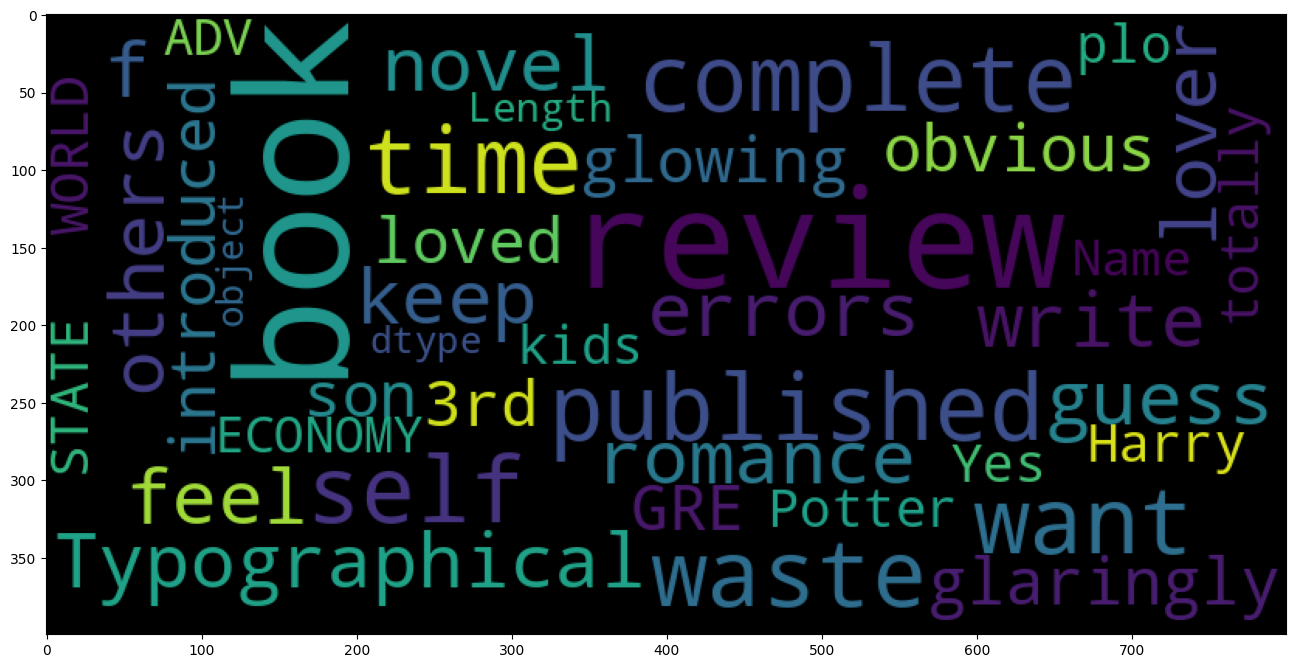

In [9]:
wordcloud = WordCloud(background_color = 'black', stopwords = STOPWORDS, max_words = 100, max_font_size = 100, random_state = 15, width = 800, height = 400)

plt.figure(figsize = (16, 12))
wordcloud.generate(str(df.loc[df['is_positive'] == 0, 'review']))
plt.imshow(wordcloud)

### Title - positive

Since the review itself might contain less of the words that people instantly associate with a positive or negative review, here are the most important words from the title, which mostly already contain only a few words.

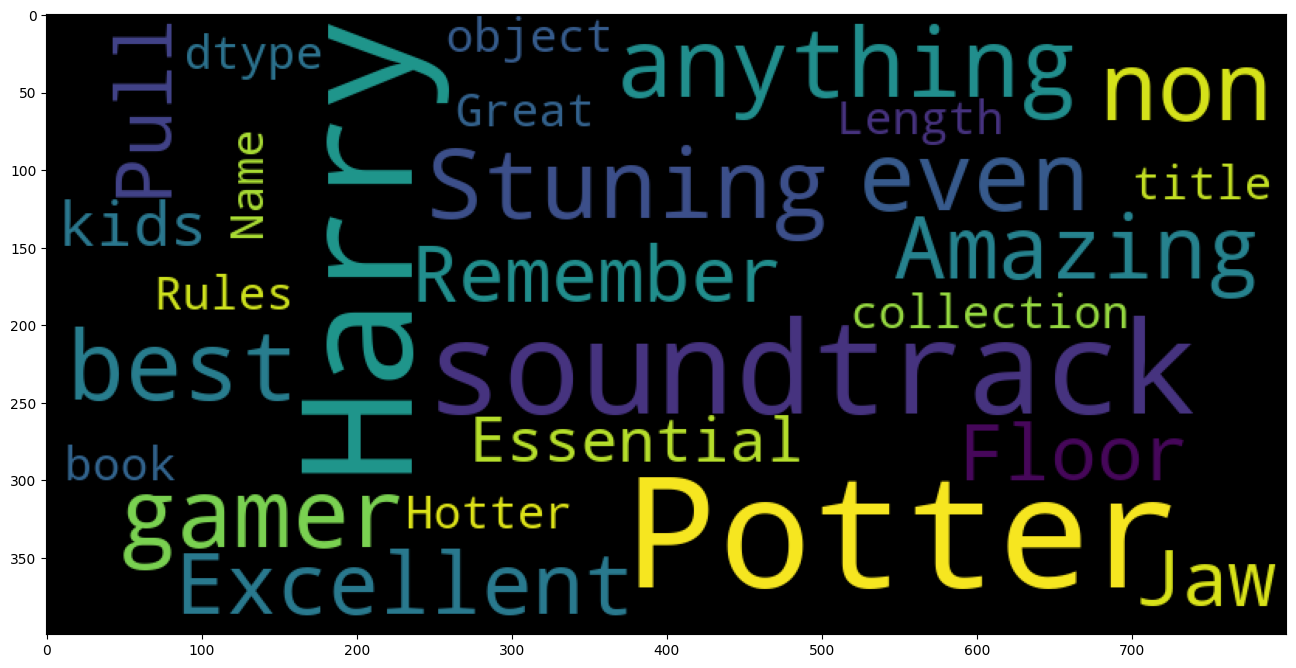

In [10]:
wordcloud = WordCloud(background_color = 'black', stopwords = STOPWORDS, max_words = 100, max_font_size = 100, random_state = 15, width = 800, height = 400)

plt.figure(figsize = (16, 12))
wordcloud.generate(str(df.loc[df['is_positive'] == 1, 'title']))
plt.imshow(wordcloud)

### Title - negative

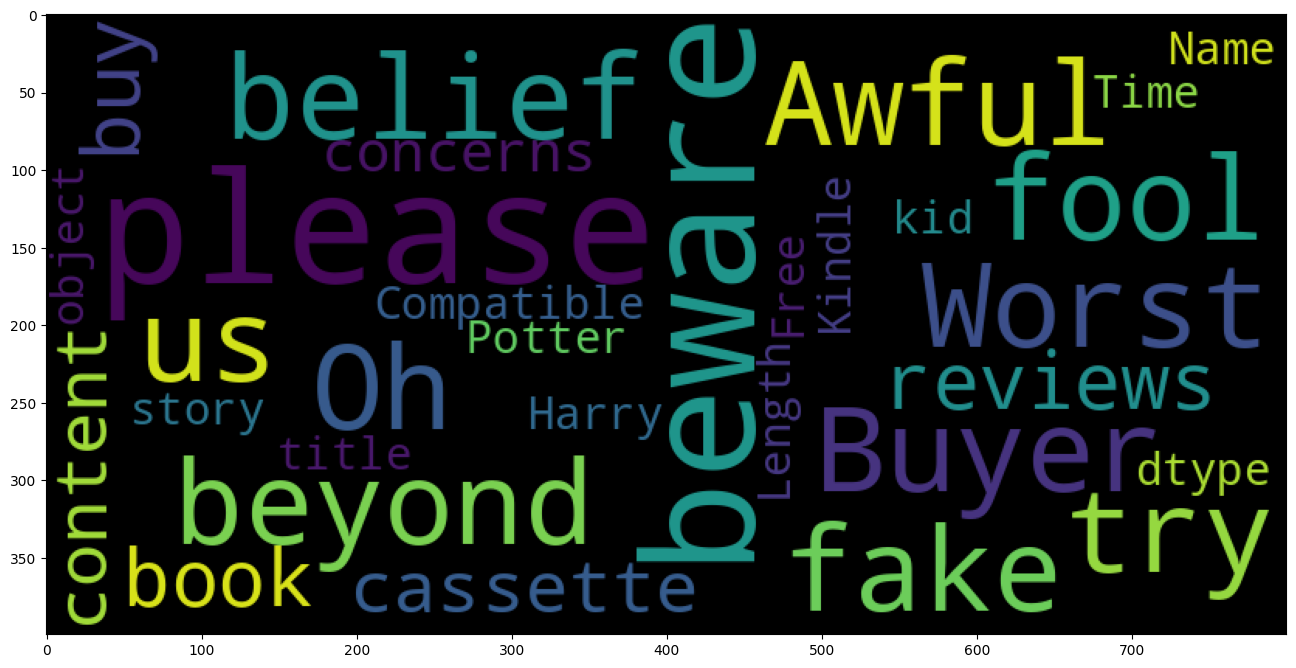

In [11]:
wordcloud = WordCloud(background_color = 'black', stopwords = STOPWORDS, max_words = 100, max_font_size = 100, random_state = 15, width = 800, height = 400)

plt.figure(figsize = (16, 12))
wordcloud.generate(str(df.loc[df['is_positive'] == 0, 'title']))
plt.imshow(wordcloud)

Here, we can see a clear distinction between positive and negative reviews. These probably make it easier to classify the different reviews, simply because these are very strong and one-sided words.

### What the model should predict

Our goal is to predict whether an amazon review is positive (1) or negative (0), based on the title and review description.

### train - test split

In [12]:
# df = df[["is_positive", "review"]]

In [13]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

We are splitting our data here into 80% train, 10% validation and 10% test.

In [14]:
len(train), len(val), len(test)

(80000, 10000, 10000)

In [34]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('is_positive')
  df = df["review"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [35]:
train_data = df_to_dataset(train)
val_data = df_to_dataset(val)
test_data = df_to_dataset(test)

## Embedding + Model

This step is necessary to make the model understand the text as numbers.
We are using TensorFlow's token based text embedding model which is trained on English Google News 7B corpus.

In [18]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [19]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.40248144,  0.16325901, -0.01408691, ..., -0.22180142,
         0.13833372,  0.13855006],
       [ 0.3616941 ,  0.09259764, -0.00805571, ...,  0.05381672,
        -0.03999288, -0.11183861],
       [ 0.4643955 ,  0.19186766,  0.14984776, ..., -0.54255384,
         0.25775626,  0.11548033],
       ...,
       [ 0.5192314 , -0.12632158,  0.03468847, ..., -0.03553058,
         0.05746029,  0.3194905 ],
       [ 0.25339228,  0.21864668,  0.00186325, ..., -0.2644687 ,
         0.19224417,  0.22807695],
       [ 0.5257941 , -0.15141474, -0.61744887, ..., -0.23634195,
         0.4508087 ,  0.2163923 ]], dtype=float32)>

In [20]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label:text))

In [21]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'i', 'a', 'to', 'of', 'it', 'this',
       'is', 'in', 'that', 'for', 'was', 'you', 'book', 'but', 'with',
       'not'], dtype='<U14')

## RNN

In this model, we use the pretrained TensorFlow layer, as well as an Embedding layer that maps the input vocabulary indices to dense vectors of fixed size 32.
It also has the SimpleRNN layer with 32 units. This processes the sequence of embedded input vectors and produces a sequence of hidden states.
At the end there is a dense dalyer with a single output unit and sigmoid activation function, which produces the binary classification output.

In [22]:
modelRNN = tf.keras.Sequential()
modelRNN.add(hub_layer)
modelRNN.add(tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=32))
modelRNN.add(tf.keras.layers.SimpleRNN(32))
modelRNN.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [23]:
# #compile
# modelRNN.compile(optimizer='rmsprop',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])


modelRNN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    loss=tf.keras.losses.BinaryCrossentropy(),
                    metrics=['accuracy'])


In [24]:
# train

history = modelRNN.fit(train_data, epochs=10, batch_size=128, validation_data=val_data)

Epoch 1/10


79/79 [==============================] - 11s 78ms/step - loss: 0.6904 - accuracy: 0.5321 - val_loss: 0.6959 - val_accuracy: 0.5319
Epoch 2/10
79/79 [==============================] - 7s 92ms/step - loss: 0.6901 - accuracy: 0.5392 - val_loss: 0.6908 - val_accuracy: 0.5329
Epoch 3/10
79/79 [==============================] - 10s 122ms/step - loss: 0.6894 - accuracy: 0.5394 - val_loss: 0.6909 - val_accuracy: 0.5326
Epoch 4/10
79/79 [==============================] - 12s 147ms/step - loss: 0.6893 - accuracy: 0.5392 - val_loss: 0.6914 - val_accuracy: 0.5336
Epoch 5/10
79/79 [==============================] - 7s 92ms/step - loss: 0.6894 - accuracy: 0.5393 - val_loss: 0.6910 - val_accuracy: 0.5325
Epoch 6/10
79/79 [==============================] - 10s 121ms/step - loss: 0.6893 - accuracy: 0.5393 - val_loss: 0.6911 - val_accuracy: 0.5330
Epoch 7/10
79/79 [==============================] - 5s 64ms/step - loss: 0.6892 - accuracy: 0.5395 - val_loss: 0.6910 - val_accuracy: 0.5324
Epoch 8/10
79/79 

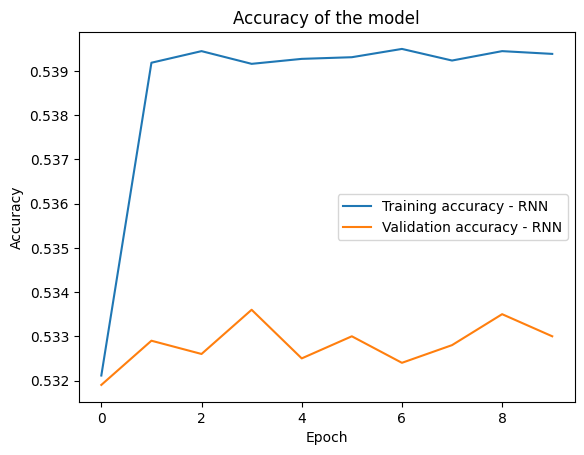

In [25]:
plt.plot(history.history['accuracy'], label="Training accuracy - RNN")
plt.plot(history.history['val_accuracy'], label="Validation accuracy - RNN")
plt.title("Accuracy of the model")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

Both training and validation accuracy are barely changing and stay around the same percentage.

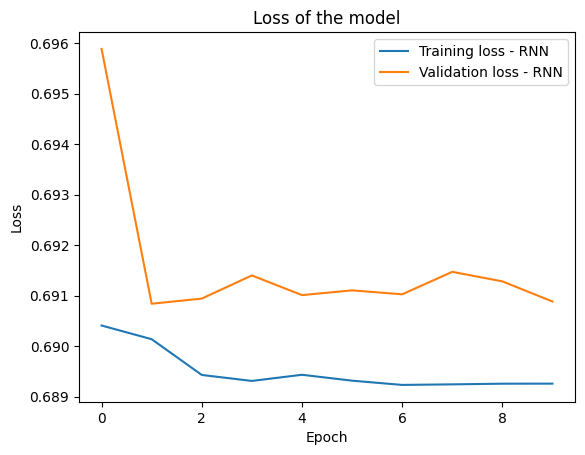

In [26]:
plt.plot(history.history['loss'], label="Training loss - RNN")
plt.plot(history.history['val_loss'], label="Validation loss - RNN")
plt.title("Loss of the model")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

Our validation loss decreases more than the training loss, but both stay around the same percentage after 2 epochs.

## CNN

This model also includes the pretrained TensorFlow layer, as well as an embedding layer that maps the input vocabulary indices to dense vectors of fixed size 32, two Conv1D layers with 32 filters of size 7 and ReLU activation function. This performs convolutional operations on the sequence of embedded input vectors to extract local features.
It also has a MaxPooling1D layer with a pool size of 5, which reduces the dimensionality of the output Conv1D layer.
The GlobalMaxPooling1D layer takes the maximum value over time for each feature map, reducing the output to a fixed-length vector.
The dense layer with a single output unit and linear function produces the binary classification output.

In [44]:
modelCNN = tf.keras.Sequential()
modelCNN.add(hub_layer)
modelCNN.add(tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=32)) 
modelCNN.add(tf.keras.layers.Conv1D(32, 7, activation='relu')) 
modelCNN.add(tf.keras.layers.MaxPooling1D(5)) 
modelCNN.add(tf.keras.layers.Conv1D(32, 7, activation='relu')) 
modelCNN.add(tf.keras.layers.GlobalMaxPooling1D())
modelCNN.add(tf.keras.layers.Dense(1))

In [45]:
modelCNN.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),  # set learning rate
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [46]:
# train

history = modelCNN.fit(train_data, epochs=10, batch_size=128, validation_data=val_data)

Epoch 1/10


79/79 [==============================] - 10s 43ms/step - loss: 1.4839 - accuracy: 0.4869 - val_loss: 0.9443 - val_accuracy: 0.4852
Epoch 2/10
79/79 [==============================] - 2s 20ms/step - loss: 0.7615 - accuracy: 0.4862 - val_loss: 0.6936 - val_accuracy: 0.5148
Epoch 3/10
79/79 [==============================] - 2s 21ms/step - loss: 0.6937 - accuracy: 0.5101 - val_loss: 0.6943 - val_accuracy: 0.5148
Epoch 4/10
79/79 [==============================] - 2s 21ms/step - loss: 0.6933 - accuracy: 0.5093 - val_loss: 0.6933 - val_accuracy: 0.5147
Epoch 5/10
79/79 [==============================] - 2s 21ms/step - loss: 0.6930 - accuracy: 0.5127 - val_loss: 0.6931 - val_accuracy: 0.4844
Epoch 6/10
79/79 [==============================] - 2s 21ms/step - loss: 0.6927 - accuracy: 0.5137 - val_loss: 0.6938 - val_accuracy: 0.4857
Epoch 7/10
79/79 [==============================] - 3s 32ms/step - loss: 0.6925 - accuracy: 0.5158 - val_loss: 0.6923 - val_accuracy: 0.5147
Epoch 8/10
79/79 [=====

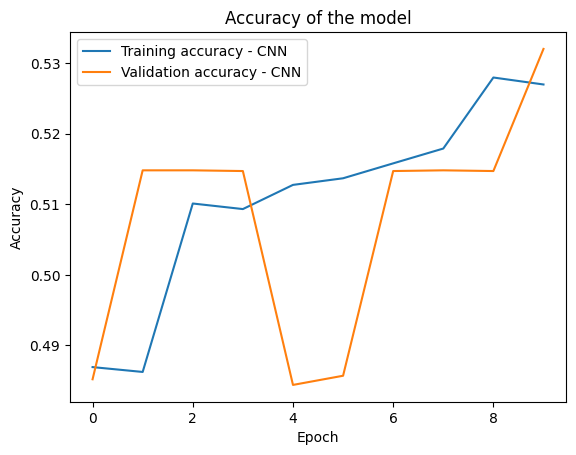

In [47]:
plt.plot(history.history['accuracy'], label="Training accuracy - CNN")
plt.plot(history.history['val_accuracy'], label="Validation accuracy - CNN")
plt.title("Accuracy of the model")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

Similar for CNN, the accuracy doesn't get any higher than mid-50s.

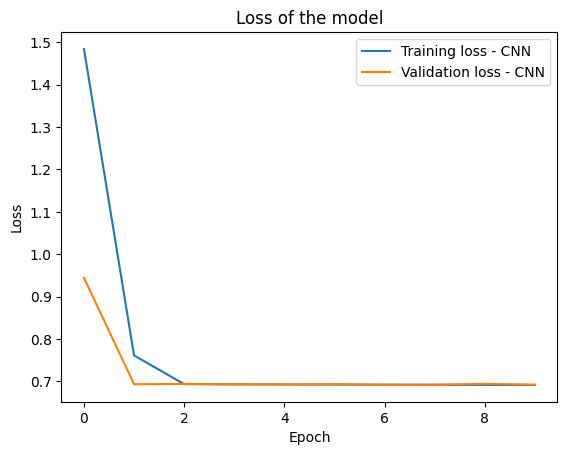

In [48]:
plt.plot(history.history['loss'], label="Training loss - CNN")
plt.plot(history.history['val_loss'], label="Validation loss - CNN")
plt.title("Loss of the model")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

The loss here, on the other hand, drops drastically after the first epoch.

## Other

I have found this model online and wanted to try it on the dataset.
We are again using the pre-trained layer from TensorFlow, as well as 2 dense layers with 16 units and the ReLU activation function.
We also use 2 dropout layers in between to reduce overfitting.
At the end, we have a final dense layer with a single unit and sigmoid activation function to produce the binary classification output.

In [49]:
model3 = tf.keras.Sequential()
model3.add(hub_layer)
model3.add(tf.keras.layers.Dense(16, activation='relu'))
model3.add(tf.keras.layers.Dropout(0.4))
model3.add(tf.keras.layers.Dense(16, activation='relu'))
model3.add(tf.keras.layers.Dropout(0.4))
model3.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [50]:

model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    loss=tf.keras.losses.BinaryCrossentropy(),
                    metrics=['accuracy'])

In [51]:
# train

history = model3.fit(train_data, epochs=10, batch_size=128, validation_data=val_data)

Epoch 1/10
79/79 [==============================] - 24s 273ms/step - loss: 0.6680 - accuracy: 0.5841 - val_loss: 0.5796 - val_accuracy: 0.7560
Epoch 2/10
79/79 [==============================] - 17s 218ms/step - loss: 0.5044 - accuracy: 0.7682 - val_loss: 0.3805 - val_accuracy: 0.8359
Epoch 3/10
79/79 [==============================] - 21s 265ms/step - loss: 0.3603 - accuracy: 0.8600 - val_loss: 0.3415 - val_accuracy: 0.8542
Epoch 4/10
79/79 [==============================] - 16s 202ms/step - loss: 0.2938 - accuracy: 0.8939 - val_loss: 0.3396 - val_accuracy: 0.8534
Epoch 5/10
79/79 [==============================] - 17s 209ms/step - loss: 0.2513 - accuracy: 0.9118 - val_loss: 0.3564 - val_accuracy: 0.8525
Epoch 6/10
79/79 [==============================] - 15s 188ms/step - loss: 0.2204 - accuracy: 0.9266 - val_loss: 0.3816 - val_accuracy: 0.8479
Epoch 7/10
79/79 [==============================] - 11s 142ms/step - loss: 0.1924 - accuracy: 0.9366 - val_loss: 0.4076 - val_accuracy: 0.8449

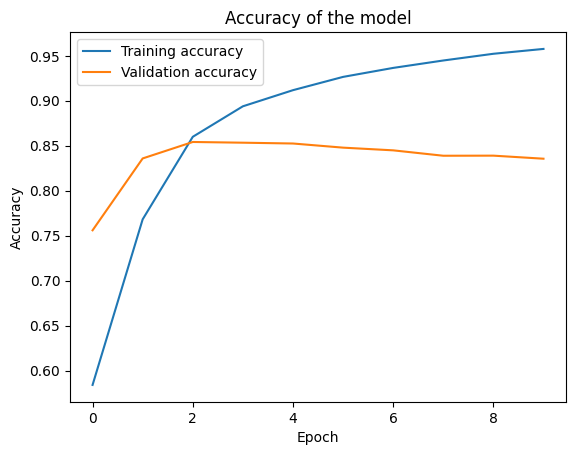

In [52]:
plt.plot(history.history['accuracy'], label="Training accuracy")
plt.plot(history.history['val_accuracy'], label="Validation accuracy")
plt.title("Accuracy of the model")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

As we can see, our training accuracy keeps getting better, while our validation accuracy does well and then slowly decreases.

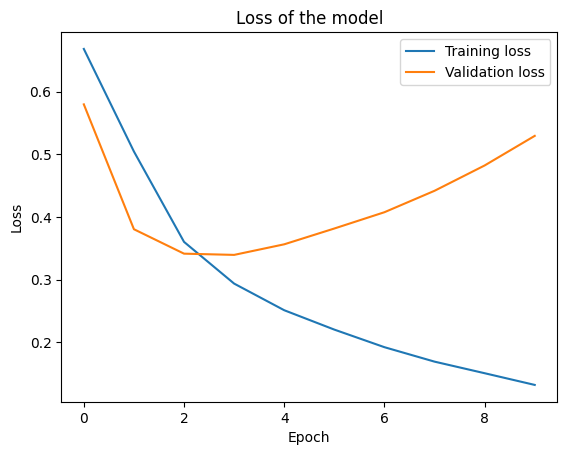

In [53]:
plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.title("Loss of the model")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

Our training loss decreases well, while our validation loss first decreases but then increases.

## Analysis

As we can see, the third model was by far the most effective one with an accuracy of up to 95%.

The RNN model, although not successful in this case, is suitable for tasks such as sentiment analysis or spam detection, where the input is a sequence of words or text.

The CNN model, again, also not very successful here, is usually also suitable for text classification and sentiment analysis, or spam detection.

The third model is very simple and effective for text classification, but may not be as powerful as more complex architectures such as RNNs or CNNs, although more successful in our case.